<a href="https://colab.research.google.com/github/fernanda-valente-postgraduate/pos-graduacao-ciencia-de-dados/blob/main/projeto-sprint-3/Fernanda_Valente_MVP_Maching_Learning_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP da Pós-graduação em Ciência de Dados e Analytics - Sprint Maching Learning & Analytics
## Aluna: Fernanda Pires Valente
**Notebook 1**

O trabalho deste MVP está dividido em 2 notebooks.

No notebook 1 (este notebook) iremos definir o objetivo do projeto, explicar de onde vem as informações utilizadas, analisar os dados, trabalhar no pré-processamento dos mesmo para a ingestão no modelo

No notebook 2 iremos Divisão dos Dados em Treinamento e Teste, construir o Modelo de Rede Neural (LSTM), treinar o Modelo e avaliar o Modelo.


# 1 Objetivo do Projeto

Será que é possível criar um modelo preditivo para identificar automaticamente se um feedback de usuários do Spotify é positivo ou negativo, utilizando técnicas de Processamento de Linguagem Natural (NLP)?

A motivação para a escolha desse tema está na relevância estratégica de compreender a percepção dos usuários de maneira rápida e escalável. Se for possível automatizar essa classificação, então empresas como o Spotify podem melhorar a experiência do usuário, identificar problemas recorrentes e priorizar melhorias com base em dados reais.

Este problema é classificado como um problema de aprendizado supervisionado, pois o modelo será treinado com um conjunto de dados rotulado, onde já sabemos se os feedbacks são positivos ou negativos. O foco do trabalho será no desenvolvimento de redes neurais para o problema.


# 2 Origem e descrição dos dados

O Dataset utilizado para responder a nossa pergunta será o *Spotify User Reviews* disponibilizado pela Alexandra Kim no Kaggle utilizando a licença [Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/). Os dados se encontram [neste link](https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset).

O conjunto de dados consiste em 1 arquivo csv com 2 colunas. Pela descrição no Kaggle, o dataset possue mais que 51 mil avaliações de usuários do aplicativo Spotify coletadas na Google Play Store (janeiro a julho de 2022). Cada avaliação foi rotulada como "Positiva" ou "Negativa" com base em seu sentimento.

A distribuição dos sentimentos dentro do conjunto de dados é a seguinte:

*  Avaliações Positivas: 56% do total de avaliações.
*  Avaliações Negativas: 44% do total de avaliações.

Neste notebook estamos utilizando o dataset extraído no início de novembro de 2024. Ao extrair os dados percebi que existe uma mensagem indicando que eles foram atualizado há um mês. Por mais que na descrição do Kaggle indique que as informações são do ano de 2022, vamos tentar validar mais para frente se isso é verdade.


Abaixo temos nos nomes em inglês das colunas, a tradução que será feita do nome para facilitar o entendimento e a descrição do que ela representa:



## 2.1 Descrição das variáveis

1. **Review (avaliacao)**: Este campo contém o texto da avaliação ou feedback fornecido pelo usuário do Spotify. Ele reflete a opinião do usuário com relação ao aplicativo Spotify.

2. **Label (rotulo)**: Este campo indica a categorização do feedback como positivo ou negativo. É a variável target no modelo de NLP, utilizada para treinar e avaliar o modelo preditivo.

# 3 Obtenção dos dados

Extraímos o csv do Kaggle e colocamos ele em um github público. Agora iremos ler o arquivo que está disponível a todos no github

## 3.1 Bibliotecas utilizada

Nesta parte iremos importar todas as bibliotecas que precisaremos utilizar no notebook

In [1]:
# foi necessária instalar a bilbioteca contractions
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.4 MB/s eta 0:00:00


In [2]:
#Imports

import re
import nltk
import string
import warnings
import contractions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from google.colab import files
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences



## 3.2 Configurações

In [3]:
# Essa configuração permite que vejamos todas as colunas do Dataframe
pd.options.display.max_columns = None

In [4]:
# configuração para não exibir os warnings
warnings.filterwarnings("ignore")

### 3.2.1 Esquema de cores
Criando o esquema de cores do relatório.

Iremos utilizar a cor verde do Spotify para criar uma paleta de cor.


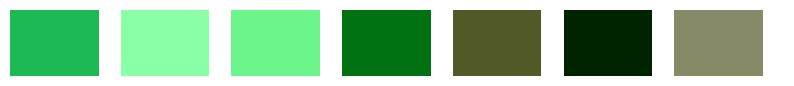

In [5]:


# Definir as cores da paleta
colors = {
    'Verde Spotify': '#1db954',
    'Verde Claro 1': '#8affa6',
    'Verde Claro 2': '#6bf58b',
    'Verde Escuro 1': '#007211',
    'Verde Musgo': '#515927',
    'Verde Escuro 2': '#002400',
    'Verde Cinza': '#868a67',
}

custom_cmap = ListedColormap(list(colors.values()))

# Criar uma figura e um eixo
fig, ax = plt.subplots(figsize=(10, 2))

# Adicionar cada cor como um retângulo na imagem
rect_width = 2
rect_height = 1.5
for i, (name, color) in enumerate(colors.items()):
    rect = patches.Rectangle((i * (rect_width + 0.5), 0), rect_width, rect_height, linewidth=0, edgecolor='none', facecolor=color)
    ax.add_patch(rect)
    #plt.text(i * (rect_width + 0.5) + rect_width / 2, rect_height / 2, name, color='black', ha='center', va='center_baseline', fontsize=12)

# Ajustar os limites do eixo e remover os eixos
ax.set_xlim(0, len(colors) * (rect_width + 0.5))
ax.set_ylim(0, rect_height)
ax.set_aspect('equal')
ax.axis('off')

# Mostrar a paleta de cores
plt.show()

## 3.3 Importação dos dados

In [6]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/fernanda-valente-postgraduate/pos-graduacao-ciencia-de-dados/main/projeto-sprint-3/DATASET_SPOTIFY.csv"

# Lê o arquivo
df = pd.read_csv(url,  delimiter=',')

Vamos agora verificar algumas questões do dataset:



*  Quantas linhas e colunas temos no dataset?



In [7]:
print('O conjunto de dados possui', df.shape[0], 'linhas (avaliações) e', df.shape[1], 'variáveis (atributos)')

O conjunto de dados possui 52702 linhas (avaliações) e 2 variáveis (atributos)


Observe que as descrições de quantidade de linhas e colunas fornecida pelo autor da base batem com o que encontramos no dataframe.

*  Como estão as 6 primeiras linhas?

In [8]:
df.head(6) # exibindo as 6 primeira linhas

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE
5,The player controls sometimes disappear for no...,NEGATIVE


*  Como estão as 6 útlimas linhas?

In [9]:
df.tail(6) # exibindo as 6 últimas linhas

,Review,label
52696,Bass volume song quality is appreciative,POSITIVE
52697,Yes the best,POSITIVE
52698,Spotify won my heart in Feb 2024 You won my he...,POSITIVE
52699,I tried to open the app and it wont open I res...,POSITIVE
52700,Good,POSITIVE
52701,Nice app to play music and at very affordable ...,POSITIVE


Olhando todo o texto da avaliação 52.698:

In [10]:
df['Review'][52698]

'Spotify won my heart in Feb 2024 You won my heart With music and lyrics and then language educational podcasts and audio books you finally won my heart over With just a free trial and I was convinced I found what I have been looking for all these while and finally settling down with this like marriage haha'

Traduzindo para português:

*O Spotify conquistou meu coração em fevereiro de 2024. Você conquistou meu coração com música e letras e, em seguida, podcasts educacionais de idiomas e audiolivros, você finalmente conquistou meu coração com apenas um teste gratuito e fiquei convencido de que encontrei o que procurava durante todo esse tempo e finalmente me acomodando com isso como se fosse um casamento haha*

Perceba que na avaliação 52.698 o usuário fala de Fevereiro de 2024 como se já tivesse passado, como se essa avaliação tivesse sido feita depois de Julho 2022. Ao meu ver, o período dos dados não parece estar limitado entre Janeiro e Julho de 2022, porém como não temos uma coluna com data não podemos determinar com certeza qual o período final dos dados.

Vamos renomear os nomes dos campos para ficar em português e em minúsculo

In [11]:
# De-para das colunas
de_para = {
    'Review': 'avaliacao',
    'label': 'rotulo',
}

# Renomear as colunas
df.rename(columns=de_para, inplace=True)

# 4 Análise de dados

## 4.1 Qualidade dos dados

In [12]:
# verificando algumas informações das colunas
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   avaliacao  52686 non-null  object
 1   rotulo     52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


Como esperado, as duas colunas são string por conterem texto. Porém perceba que o dataframe contém 52.702 linhas, mas nem todas estão com a avaliação preenchida por mais que todas tenham um rótulo.

Será que essas linhas com avaliação nula tem um rótulo diferente?

In [13]:
df[df['avaliacao'].isnull()]

,avaliacao,rotulo
49679,NaN,POSITIVE
49690,NaN,POSITIVE
49747,NaN,POSITIVE
50005,NaN,POSITIVE
50397,NaN,POSITIVE
50437,NaN,POSITIVE
50802,NaN,POSITIVE
50883,NaN,POSITIVE
50972,NaN,POSITIVE
50973,NaN,POSITIVE


Todas elas estão classificadas como uma avaliação positiva, por mais que não tenha nada escrito. Iremos então excluir essas observações do conjunto de dados.

Pelo tamanho do df acima já é possível percebemos que não temos muitos casos onde isso acontece, porém antes de deletar vamos ver qual a porcentagem de observações nulas da coluna *avaliacao*.

In [14]:
# verificando a porcentagem de valores nulos nas colunas
df_null = df.isnull().mean(axis = 0)
# ficando apenas com as colunas com nulo
df_null = df_null[df_null > 0] * 100
print("Colunas com valores ausentes (qtd relativa):\n{}".format(df_null.sort_values(axis=0, ascending=False)))

Colunas com valores ausentes (qtd relativa):
avaliacao    0.030359
dtype: float64


In [15]:
df = df.dropna(subset=['avaliacao'])

In [16]:
# verificando que não temos mais informações nulas:
df[df['avaliacao'].isnull()]

,avaliacao,rotulo


Outra pergunta importante: será que temos linhas duplicadas?

In [17]:
# Há dulicidade?
df[df.duplicated()==True]

,avaliacao,rotulo
1848,Way too many ads,NEGATIVE
2391,Good app for songs,POSITIVE
2871,I love Spotify.,POSITIVE
2883,Too many ads,NEGATIVE
3020,Too much ads,NEGATIVE
...,...,...
52689,I love this app,POSITIVE
52691,Nice,POSITIVE
52692,Nice,POSITIVE
52694,You know why,POSITIVE


Antes de tomar uma decisão para remover ou não essa duplicidade vamos primeiro entender se ela faz sentido.

O nosso conjunto de dados consiste em avaliações sobre um aplicativo. Avaliações padrões como "Good" (bom) ou "Bad" (ruim) podem ocorrer com mais frequência do que avaliações mais extensas. Então o fato de ter duplicidade no conjunto de dados não indica um erro no armazenamento das informações pois usuários diferentes podem escrever a mesma avaliação.

Podemos seguir por dois caminhos, manter ou remover a duplicidade.

Justificativa para **manter** duplicatas:


*   Se a frequência de um determinado texto (como "Bom") reflete um comportamento real dos usuários e a gente deseja que o modelo aprenda com essa distribuição, é importante mantê-las.
*   A repetição pode fornecer informações úteis para o modelo sobre a predominância de sentimentos em textos curtos e comuns.


Justificativa para **remover** duplicatas:

*   Duplicatas podem enviesar o modelo, fazendo com que ele superestime a importância de textos comuns e curtos, como "Bom".
*   A remoção pode reduzir o tamanho do dataset, tornando o treinamento mais eficiente e focando na diversidade do vocabulário e das expressões.

Vamos avaliar o quanto do nosso conjunto de dados tem de duplicatas:

In [18]:
# verificando a porcentagem de linhas duplicadas
df_dupli = df.duplicated().mean(axis = 0)*100
print("Temos {:.2f}% de duplicidade".format(df_dupli))


Temos 2.30% de duplicidade


Vamos testar treinar o modelo com e sem duplicidade para comparar os resultados.

Suposição do que irá acontecer: como o percentual de duplicatas é pequeno não acho que deixar a duplicidade causará um impacto grande no resultado.

## 4.2 Análise exploratória dos dados

Vamos nessa etapa entender algumas estatísticas gerais do conjunto de dados. Vamos:


*   Gerar a distribuição das classes do rótulo
*   Identificar a classe com maior frequência
*   Analisar o comprimento dos textos na coluna avaliação
*   Entender as principais palavras de cada classe





---



In [19]:
# vendo uma descrição geral dos dados
df.describe().T

,count,unique,top,freq
avaliacao,52686,51472,Good,153
rotulo,52686,2,NEGATIVE,29423


In [20]:
# vendo como a variável target está distribuída
print("\nDistribuição de classes (valor absoluto):")
print(df['rotulo'].value_counts())
print("\nDistribuição de classes (representatividade):")
print(df['rotulo'].value_counts(normalize=True))


Distribuição de classes (valor absoluto):
rotulo
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64

Distribuição de classes (representatividade):
rotulo
NEGATIVE    0.55846
POSITIVE    0.44154
Name: proportion, dtype: float64


Com esses resultados podemos chegar a algumas conclusões do conjunto de dados:


1.   A palavra que aperece com mairo frequência nas avaliações é *Good*, com 153 aparições.
2.   No geral, temos um volume equilibrado de avaliações negativas e positivas, com as avaliações negativas se destacando um pouco representando 55.8% dos dados
3.  Só temos duas possíveis entradas na coluna rótulo, *NEGATIVE* e *POSITIVE*. Ou seja não temos a classificação de avaliação neutra.





---



In [21]:
# vendo o comprimento das avaliações
df['comprimento_texto'] = df['avaliacao'].dropna().apply(len)
print("\nEstatísticas sobre o comprimento dos textos:")
print(df['comprimento_texto'].describe())


Estatísticas sobre o comprimento dos textos:
count    52686.000000
mean       151.388604
std        120.626998
min          2.000000
25%         60.000000
50%        117.000000
75%        208.000000
max       1693.000000
Name: comprimento_texto, dtype: float64


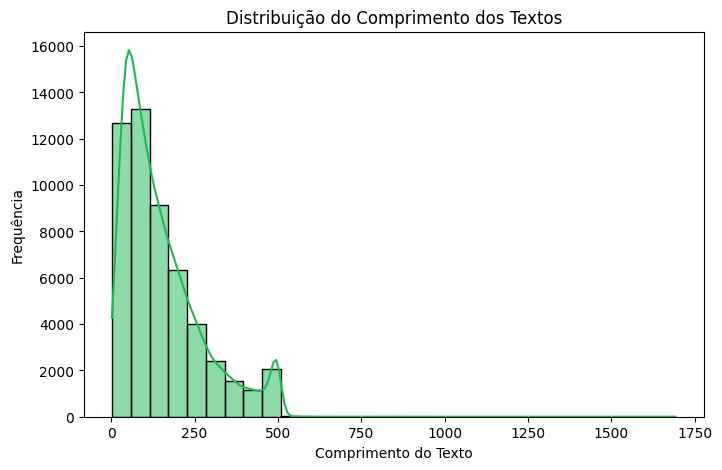

In [22]:
# Histograma do comprimento dos textos
plt.figure(figsize=(8, 5))
sns.histplot(df['comprimento_texto'], bins=30, kde=True, color=colors['Verde Spotify'])
plt.title("Distribuição do Comprimento dos Textos")
plt.xlabel("Comprimento do Texto")
plt.ylabel("Frequência")
plt.show()

In [23]:
# calcular os percentis
percentis = [0.80, 0.85, 0.90, 0.95, 0.99]
valores_percentis = df['comprimento_texto'].quantile(percentis)

# exibir os resultados
print("Percentis dos comprimentos dos textos:")
print(valores_percentis)

Percentis dos comprimentos dos textos:
0.80    236.0
0.85    272.0
0.90    328.0
0.95    427.0
0.99    498.0
Name: comprimento_texto, dtype: float64


Perceba que:


*   Cinquenta porcento das avaliações possuem até 117 caracteres.
*   A menor avaliação possuem 2 caracteres (muito provavelmente será a palavra Ok).
*   A maior avaliação possue 1.693 caracteres.
*   Praticamente todas as avaliações possuem até 500 caracteres, cerca de 99% das avaliações. Além disso, a frequência na faixa próxima de 500 caracteres é relativamente maior que as faixas vizinhas. Essas estatísticas levantam algumas perguntas. Será que a partir de uma data foi imposto um limite menor de caracteres? Será que essas avaliações extensas são um erro? Será que todas essas avaliações com mais de 500 caracteres são negativas? Ou será que são positivas?
    *  Caso haja tem iremos tentar responder essas perguntas no final do projeto.


In [24]:
# filtrar avaliações com exatamente 117 caracteres
avaliacao_117 = df[df['avaliacao'].dropna().apply(len) == 117]
# 2 caracteres
avaliacao_2 = df[df['avaliacao'].dropna().apply(len) == 2]
# 12 caracteres
avaliacao_12 = df[df['avaliacao'].dropna().apply(len) == 12]

# mostrar apenas o primeiro como exemplo:
print("Exemplo de avaliação com 117 caracteres:")
print(avaliacao_117['avaliacao'].iloc[0])

print("")
print("Exemplo de avaliação com 12 caracteres:")
print(avaliacao_12['avaliacao'].iloc[0])

print("")
print("Exemplo de avaliação com 2 caracteres:")
print(avaliacao_2['avaliacao'].iloc[0])

Exemplo de avaliação com 117 caracteres:
Very good and the exact app I was looking for. 1 star not given because of too many ads and some songs are not there.

Exemplo de avaliação com 12 caracteres:
Too much ads

Exemplo de avaliação com 2 caracteres:
Ok




---



In [25]:
# distribuição de palavras por classe
df['qtd_palavras'] = df['avaliacao'].dropna().apply(lambda x: len(x.split()))

print("\nEstatísticas de palavras por texto:")
print(df.groupby('rotulo')['qtd_palavras'].describe())



Estatísticas de palavras por texto:
            count       mean        std  min   25%   50%   75%    max
rotulo                                                               
NEGATIVE  29423.0  35.920232  23.686223  2.0  18.0  30.0  48.0  423.0
POSITIVE  23263.0  19.108670  17.671005  1.0   7.0  13.0  25.0  175.0


Agora não estamos mais olhando para caracteres e sim para palavras. Perceba que no geral as avaliações positivas tem menos palavras que as negativas.

*   O número máximo de palavras numa avaliação negativa é de 423 enquanto que na avaliação positiva é 175.
*   Cinquenta porcento das avaliações negativas usaram até 30 palavras enquanto que o mesmo percentural nas avaliações positivas usam até 13 palavras.
*   A média de palavras das avaliações negativas é de 36 enquanto que das avaliações positivas é de 19.



---



In [26]:
# Exibir alguns exemplos de texto por classe
print("\nExemplos de textos por classe:")
for rotulo in df['rotulo'].unique():
    print(f"\nRótulo: {rotulo}")
    print(df[df['rotulo'] == rotulo]['avaliacao'].tail(3).tolist())


Exemplos de textos por classe:

Rótulo: POSITIVE
['I tried to open the app and it wont open I restarted my phone but Ill tap the icon itll freeze and then send me to my home screen I uninstalled and reinstalled and that fixed it for a day but now its happening again I dont want to have to redownload everything again', 'Good ', 'Nice app to play music and at very affordable price']

Rótulo: NEGATIVE
["Love it. Not a day goes by where I don't listen to Spotify. It would be cool if there was a shuffle playlists feature ðŸ˜\x81", 'Good for android watch not for ios. It works perfectly with my galaxy watch but for Apple watch this app is worst, constant crashes, and offline mode issues faced in Apple watch.', "Has become absolutely horrible, can't play music while opening another app without the whole spotify app closing. Checked all settings none restricting it from background activity, yet it still crashes/stops playing everytime i leave the app."]




---



Gerando uma nuvem de palavras para os rótulos positivos e negativos:

Primeiro vamos verificar quantas palavras única temos no conjunto de dados.

In [27]:
textos = df['avaliacao'].dropna()

# Unir todos os textos em uma única string
texto_unico = " ".join(textos)

# Contar a frequência das palavras
contador = Counter(texto_unico.split())
print(len(contador))

56934


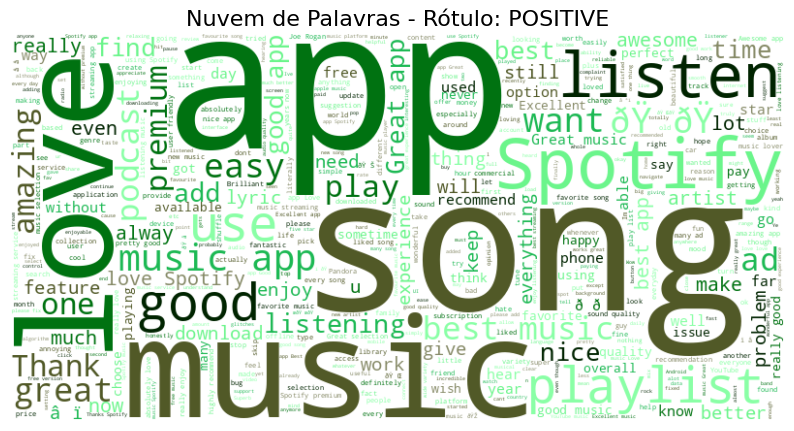

----------------------------------------------------------------------------------------------------------------------------


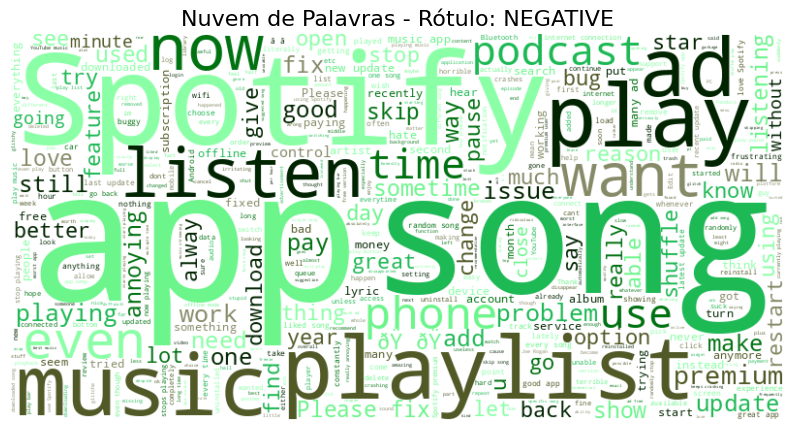

----------------------------------------------------------------------------------------------------------------------------


In [28]:
# Função para gerar nuvem de palavras para um rótulo específico
def gerar_nuvem_palavras(textos, titulo, cmap):
    # Unir todos os textos em uma única string
    texto_unico = " ".join(textos)

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=cmap,
        max_words=60000, # vamos colocar limte de 60mil palavras pois temos 57mil palavras distintas
        contour_color='black',
        min_word_length = 1
    ).generate(texto_unico)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=16)
    plt.show()

# Gerar a nuvem de palavras para cada rótulo
for rotulo in df['rotulo'].unique():
    textos_rotulo = df[df['rotulo'] == rotulo]['avaliacao'].dropna()
    titulo = f"Nuvem de Palavras - Rótulo: {rotulo}"
    gerar_nuvem_palavras(textos_rotulo, titulo, custom_cmap)
    print("----------------------------------------------------------------------------------------------------------------------------")

Observe que, em ambos os rótulos, as palavras mais frequentes não expressam uma opinião clara. Por exemplo, termos como *app*, *song*, *music*, *listen* e *Spotify* não indicam se o usuário teve uma experiência positiva ou negativa com o aplicativo.

Vamos ver quais as 10 palavras mais frequentes de cada rótulo:

In [29]:
# Função para contar palavras e mostrar as top 10
def top_palavras_por_categoria(df, coluna_texto, coluna_rotulo):
    categorias = df[coluna_rotulo].unique()  # Obter categorias únicas
    for categoria in categorias:
        # Filtrar textos da categoria atual
        textos = df[df[coluna_rotulo] == categoria][coluna_texto].dropna()

        # Unir todos os textos em uma única string
        texto_unico = " ".join(textos)

        # Contar a frequência das palavras
        contador = Counter(texto_unico.split())
        print(len(contador))
        # Obter as 10 palavras mais frequentes
        top_10_palavras = contador.most_common(10)

        # Exibir o resultado
        print(f"\nTop 10 palavras para a categoria '{categoria}':")
        for palavra, frequencia in top_10_palavras:
            print(f"{palavra}: {frequencia}")

# Executar a função
top_palavras_por_categoria(df, coluna_texto='avaliacao', coluna_rotulo='rotulo')

26528

Top 10 palavras para a categoria 'POSITIVE':
I: 15356
to: 14176
the: 13471
and: 12077
music: 9316
app: 8059
is: 7710
it: 7533
a: 6925
for: 6117
42890

Top 10 palavras para a categoria 'NEGATIVE':
the: 38013
to: 36823
I: 31436
and: 23901
it: 19233
a: 18426
is: 15083
app: 13434
my: 12295
of: 10929


Perceba que as top 10 palavras de cada rótulo não são as que aparecem com maior tamanho na nuvem de palavras. Isso se dá pois ao rodar o wordcloud.generate() ele automaticamente já retira as tão conhecidas stopwords.

Vamos gerar de novo a nuvem de palavras porém agora já passando a frequência de cada uma para mostrar como o resultado pode ser diferente dependendo das configurações e função aplicadas.

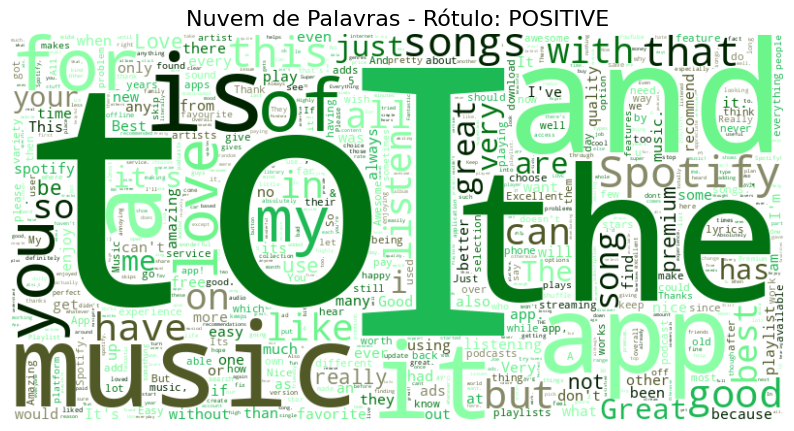

----------------------------------------------------------------------------------------------------------------------------


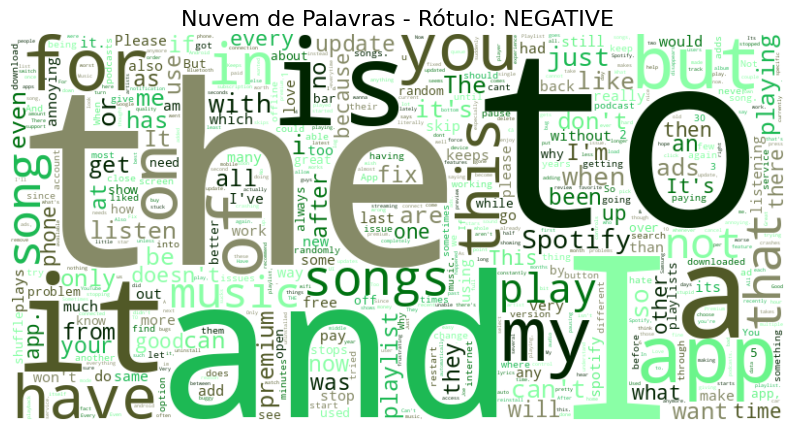

----------------------------------------------------------------------------------------------------------------------------


In [30]:
# Função para gerar nuvem de palavras para um rótulo específico usando generate_from_frequencies
def gerar_nuvem_palavras_freq(textos, titulo, cmap):
    # Unir todos os textos em uma única string
    texto_unico = " ".join(textos)

    # Contar a frequência das palavras
    contador = Counter(texto_unico.split())

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=cmap,
        max_words=60000, # vamos colocar limte de 60mil palavras pois temos 57mil palavras distintas
        contour_color='black',
        min_word_length = 1
    ).generate_from_frequencies(contador)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=16)
    plt.show()

# Gerar a nuvem de palavras para cada rótulo
for rotulo in df['rotulo'].unique():
    textos_rotulo = df[df['rotulo'] == rotulo]['avaliacao'].dropna()
    titulo = f"Nuvem de Palavras - Rótulo: {rotulo}"
    gerar_nuvem_palavras_freq(textos_rotulo, titulo, custom_cmap)
    print("----------------------------------------------------------------------------------------------------------------------------")

As palavras que apareceram com destaque nas nuvens são conhecidas como stopwords, ou seja, palavras muito comuns que geralmente não carregam significado relevante em análises de texto. Precisamos limpar essas palavras do nosso conjunto de dados para entender melhor a essência de cada rótulo.

#5 Pré-Processamento - Parte 1

Nesta etapa iremos trabalhar no pré-processamento dos Dados. É essencial preparar os textos para alimentar a rede neural, aqui iremos filtrar palavras genéricas, normalizar os textos, remover palavras raras, expandir contrações, stemização/lematização, sequenciamento e padding.

## 5.1 Expansão de contrações

Nesta etapa iremos substituir contrações para melhorar a qualidade semântica (exemplo: don't → do not).

In [31]:
# Função para expandir contrações
def expandir_contracoes(texto):
    return contractions.fix(texto)

df['avaliacao_expandida'] = df['avaliacao'].apply(expandir_contracoes)

In [32]:
# Exibir exemplo
# escolhemos a nona observação para mostrar a diferença
print("Texto original:")
print(df['avaliacao'].iloc[9])
print("\nTexto expandido:")
print(df['avaliacao_expandida'].iloc[9])

Texto original:
I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer doesn't want to pay for music they can't fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I'm more patient than most. If those are the only ways you can profit: you've already peaked. All that's left is your decline.

Texto expandido:
I am deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer does not want to pay for music they cannot fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I am more patient than most. If those are the only ways you can profit: you have already peaked. All that is left is your decline.


## 5.2 Filtragem de palavras genéricas

Nesta etapa iremos utilizar a biblioteca NLTK para retirar as palavras que não serão úteis para identificar se um feedback de usuários do Spotify é positivo ou negativo.


In [33]:
# Baixar pacotes necessários
nltk.download('stopwords')
nltk.download('punkt_tab')

# Obter lista de stopwords em inglês como um conjunto
stop_words = set(stopwords.words('english'))

# Adicionar palavras adicionais irrelevantes ao conjunto de stopwords
additional_stopwords = {'app', 'music', 'play', 'spotify', 'song', 'songs', 'listen', 'playing', 'get', 'playlist'}
stop_words.update(additional_stopwords)

# Verificar se as palavras foram adicionadas
print("Palavras adicionais foram adicionadas?")
print(additional_stopwords.issubset(stop_words))  # Deve retornar True


# Função para filtrar stopwords e pontuações
from nltk.tokenize import word_tokenize
import string

def filtrar_stopwords(texto):
    # Dividir o texto em palavras
    palavras = word_tokenize(texto)
    # Remover stopwords e pontuações
    palavras_filtradas = [palavra for palavra in palavras if palavra.lower() not in stop_words  and palavra not in string.punctuation]
    return " ".join(palavras_filtradas)

df['avaliacao_filtrada'] = df['avaliacao_expandida'].apply(filtrar_stopwords)

# Exibir exemplo de texto filtrado
print("Texto original:")
print(df['avaliacao'].iloc[0])
print("\nTexto expandido:")
print(df['avaliacao_expandida'].iloc[0])
print("\nTexto filtrado:")
print(df['avaliacao_filtrada'].iloc[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Palavras adicionais foram adicionadas?
True
Texto original:
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.

Texto expandido:
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.

Texto filtrado:
Great service audio high quality easy use Also quick friendly support


Verificando quais são as palavras retiradas:

In [34]:
# Exibir exemplo de texto filtrado
print("Texto original:")
print(df['avaliacao'].iloc[9])
print("\nTexto expandido:")
print(df['avaliacao_expandida'].iloc[9])
print("\nTexto filtrado:")
print(df['avaliacao_filtrada'].iloc[9])

Texto original:
I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer doesn't want to pay for music they can't fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I'm more patient than most. If those are the only ways you can profit: you've already peaked. All that's left is your decline.

Texto expandido:
I am deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer does not want to pay for music they cannot fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I am more patient than most. If those are the only ways you can profit: you have already peaked. All that is left is your decline.

Texto filtrado:
deleting following reasons failing business model Whet

## 5.3 Normalização do texto

Nesta etapa iremos reduzir variações nos textos para padronizá-los. Isso pode incluir:

*   Transformar para minúsculas.
*   Remover caracteres especiais, números, emoji ou múltiplos espaços.



In [35]:
def normalizar_texto(texto):
    texto = texto.lower()  # Converter para minúsculas
    texto = re.sub(r'[^\w\s]', '', texto)  # Remover pontuação
    texto = re.sub(r'\d+', '', texto)  # Remover números
    texto = re.sub(r'\s+', ' ', texto).strip()  # Remover múltiplos espaços e espaços extras
    return texto

df['avaliacao_normalizada'] = df['avaliacao_filtrada'].apply(normalizar_texto)

In [36]:
# Exibir exemplo de texto filtrado
print("Texto original:")
print(df['avaliacao'].iloc[0])
print("\nTexto expandido:")
print(df['avaliacao_expandida'].iloc[0])
print("\nTexto filtrado:")
print(df['avaliacao_filtrada'].iloc[0])
print("\nTexto normalizado:")
print(df['avaliacao_normalizada'].iloc[0])

Texto original:
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.

Texto expandido:
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.

Texto filtrado:
Great service audio high quality easy use Also quick friendly support

Texto normalizado:
great service audio high quality easy use also quick friendly support


In [37]:
# Exibir exemplo de texto filtrado
print("Texto original:")
print(df['avaliacao'].iloc[9])
print("\nTexto expandido:")
print(df['avaliacao_expandida'].iloc[9])
print("\nTexto filtrado:")
print(df['avaliacao_filtrada'].iloc[9])
print("\nTexto normalizado:")
print(df['avaliacao_normalizada'].iloc[9])

Texto original:
I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer doesn't want to pay for music they can't fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I'm more patient than most. If those are the only ways you can profit: you've already peaked. All that's left is your decline.

Texto expandido:
I am deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consumer does not want to pay for music they cannot fully own, and 6 ads successively, upon logging in, before a single song, is too much. Closed the app during ad number 6, and I am more patient than most. If those are the only ways you can profit: you have already peaked. All that is left is your decline.

Texto filtrado:
deleting following reasons failing business model Whet

Agora que já aplicamos diversos tratamentos no campo da avaliação vamos gerar novamente as nuvens de palavras de cada rótulo para entender quais as palavras mais relevantes.

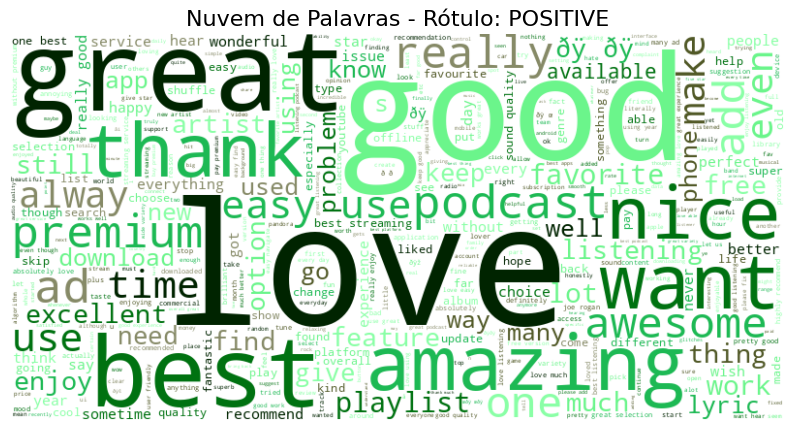

----------------------------------------------------------------------------------------------------------------------------


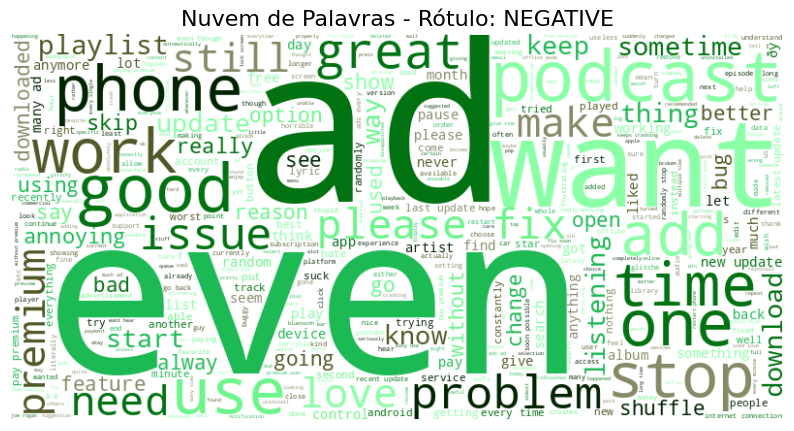

----------------------------------------------------------------------------------------------------------------------------


In [38]:
# Gerar a nuvem de palavras para cada rótulo
for rotulo in df['rotulo'].unique():
    textos_rotulo = df[df['rotulo'] == rotulo]['avaliacao_normalizada'].dropna()
    titulo = f"Nuvem de Palavras - Rótulo: {rotulo}"
    gerar_nuvem_palavras(textos_rotulo, titulo, custom_cmap)
    print("----------------------------------------------------------------------------------------------------------------------------")

Observe que no rótulo positivo, temos diversas palavras que de fato expressam opiniões positivas como *love*, *best*, *great*, *good* e *amazing*. Porém quando olhamos para a nuvem de palavras do rótulo negativo as palavras que mais aparecem não expressam a opinião do usuário de forma clara, mas sabendo sobre o contexto podemos inferir algumas coisas, como: a palavra *Ad* (anúncio/propaganda) aparece com muita frequência, provavelmente os anúncios foram relevantes para uma avaliação negativa do aplicativo.

In [39]:
# distribuição de palavras por classe
df['qtd_palavras_normalizada'] = df['avaliacao_normalizada'].dropna().apply(lambda x: len(x.split()))

print("\nEstatísticas de palavras por texto:")
print(df.groupby('rotulo')['qtd_palavras_normalizada'].describe())



Estatísticas de palavras por texto:
            count       mean        std  min  25%   50%   75%    max
rotulo                                                              
NEGATIVE  29423.0  15.211705  10.232938  0.0  8.0  13.0  20.0  409.0
POSITIVE  23263.0   8.222843   7.558322  0.0  3.0   6.0  11.0  150.0


Perceba que depois de todos os tratamento nós reduzimos alguns números, como:

Agora não estamos mais olhando para caracteres e sim para palavras. Perceba que no geral as avaliações positivas tem menos palavras que as negativas.

*   **O número máximo de palavras numa avaliação negativa** era de 423 e **passou a ser 409**, enquanto que na **avaliação positiva** era de 175 e **passou a ser 150**.
*   **Cinquenta porcento das avaliações negativas** usavam até 30 palavras, agora **usam até 13 palavras**. O mesmo percentural nas **avaliações positivas** usavam até 13 palavras e agora **usam até 6**.
*   **A média de palavras das avaliações negativas** era de 36 e passou a ser de **15** enquanto que das **avaliações positivas** era de 19 e passou a ser de **8**.

In [40]:
# calcular os percentis
percentis = [0.80, 0.85, 0.90, 0.95, 0.99]
valores_percentis = df['qtd_palavras_normalizada'].quantile(percentis)

# exibir os resultados
print("Percentis da quantidade de palavras:")
print(valores_percentis)

Percentis da quantidade de palavras:
0.80    19.0
0.85    22.0
0.90    26.0
0.95    33.0
0.99    42.0
Name: qtd_palavras_normalizada, dtype: float64


A informação dos percentis será relevante na hora de escolher um limite do padding. Como 99% dos casos tem até 42 palavras podemos escolher um limite máximo de 45 palavras que deixará as informações ainda bem completas.

In [41]:
df.head(5)

,avaliacao,rotulo,comprimento_texto,qtd_palavras,avaliacao_expandida,avaliacao_filtrada,avaliacao_normalizada,qtd_palavras_normalizada
0,"Great music service, the audio is high quality...",POSITIVE,112,21,"Great music service, the audio is high quality...",Great service audio high quality easy use Also...,great service audio high quality easy use also...,11
1,Please ignore previous negative rating. This a...,POSITIVE,86,15,Please ignore previous negative rating. This a...,Please ignore previous negative rating super g...,please ignore previous negative rating super g...,10
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE,106,19,"This pop-up ""Get the best Spotify experience o...",pop-up `` best experience Android 12 '' annoyi...,popup best experience android annoying please ...,9
3,Really buggy and terrible to use as of recently,NEGATIVE,47,9,Really buggy and terrible to use as of recently,Really buggy terrible use recently,really buggy terrible use recently,5
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE,100,21,Dear Spotify why do I get songs that I did not...,Dear put shuffle,dear put shuffle,3


#6 Divisão dos dados em Treinamento e Teste

Antes de continuar com o tratamento das avliações iremos separar os dados em conjunto de treino e teste. Iremos fazer isso nesta etapa para não haver data leakage no conjunto que irá treinar o modelo.

Como vimos nas etapas anteriores, a coluna rótulo está bem balanceada entre positivo e negativo, então iremos separar os dados usando uma amostragem simples sem reposição.

Vamos separar 80% dos dados para treino e 20% para teste.

In [42]:
# Divisão em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [43]:
# Vendo como ficou o conjunto X_train
train_df[0:4]

,avaliacao,rotulo,comprimento_texto,qtd_palavras,avaliacao_expandida,avaliacao_filtrada,avaliacao_normalizada,qtd_palavras_normalizada
16620,The app has started logging me out when I rest...,NEGATIVE,418,84,The app has started logging me out when I rest...,started logging restart phone whereas never us...,started logging restart phone whereas never us...,34
21963,This app plays so many great songs and albums ...,POSITIVE,486,91,This app plays so many great songs and albums ...,plays many great albums different types reggae...,plays many great albums different types reggae...,36
26381,It's always been my preferred streaming servic...,NEGATIVE,411,75,It is always been my preferred streaming servi...,always preferred streaming service years years...,always preferred streaming service years years...,38
25956,i recently got premium and everytime i skip to...,NEGATIVE,73,14,i recently got premium and everytime i skip to...,recently got premium everytime skip next crashes,recently got premium everytime skip next crashes,7


Verificando como que ficou a distribuição da coluna rótulo nos conjunto de teste e treino

In [44]:
train_df.rotulo.value_counts(normalize=True)

,proportion
rotulo,
NEGATIVE,0.558959
POSITIVE,0.441041


In [45]:
test_df.rotulo.value_counts(normalize=True)

,proportion
rotulo,
NEGATIVE,0.556462
POSITIVE,0.443538


#7 Pré-Processamento - Parte 2

Nesta etapa iremos continuar com o pré-processamento dos dados. Aqui iremos remover palavras raras, expandir contrações, stemização/lematização, sequenciamento e padding.

## 7.1 Remoção de Palavras Raras

Nesta etapa iremos remover palavras que aparecem poucas vezes podem não ser úteis e adicionar ruído ao modelo.

In [46]:
# Contar frequência de todas as palavras do conjunto de treino
frequencia_palavras = Counter(" ".join(train_df['avaliacao_normalizada']).split())

# Identificar palavras raras (aparecem menos de 5 vezes, por exemplo)
palavras_raras = {palavra for palavra, freq in frequencia_palavras.items() if freq < 5}

# Função para remover palavras raras
def remover_palavras_raras(texto):
    return " ".join([palavra for palavra in texto.split() if palavra not in palavras_raras])

train_df['avaliacao_sem_raras'] = train_df['avaliacao_normalizada'].apply(remover_palavras_raras)
test_df['avaliacao_sem_raras'] = test_df['avaliacao_normalizada'].apply(remover_palavras_raras)

In [47]:
# Exibir exemplo
# escolhemos a nona observação para mostrar a diferença
print("Texto original:")
print(train_df['avaliacao'].iloc[1])
print("\nTexto substituindo contrações:")
print(train_df['avaliacao_expandida'].iloc[1])
print("\nTexto filtrado:")
print(train_df['avaliacao_filtrada'].iloc[1])
print("\nTexto normalizado:")
print(train_df['avaliacao_normalizada'].iloc[1])
print("\nTexto sem palávras raras:")
print(train_df['avaliacao_sem_raras'].iloc[1])

Texto original:
This app plays so many great songs and albums of all different types from reggae, rock, soul, mellow, oldies, rap, heavy metal, hip-hop, new artists, acoustic and on and on... You can pick and choose them yourself and it's free but there's ads. If you get premium then you don't have to deal with that annoyance and interruption of music but it will cost you on a monthly basis. You can also listen to the music with the songs ðŸŽµ lyrics which is a great feature so you can sing along!

Texto substituindo contrações:
This app plays so many great songs and albums of all different types from reggae, rock, soul, mellow, oldies, rap, heavy metal, hip-hop, new artists, acoustic and on and on... You can pick and choose them yourself and it is free but there is ads. If you get premium then you do not have to deal with that annoyance and interruption of music but it will cost you on a monthly basis. You can also listen to the music with the songs ðŸŽµ lyrics which is a great featur

## 5.5 Tokenização

Nesta etapa iremos criar uma lista de palavras.

In [48]:
# Foi necessário baixar o punkt_tab
nltk.download('punkt_tab')

# Tokenização
train_df['tokens'] = train_df['avaliacao_sem_raras'].apply(word_tokenize)
test_df['tokens'] = test_df['avaliacao_sem_raras'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [49]:
# Exibir exemplo
print("Texto original:")
print(train_df['avaliacao'].iloc[0])
print("\nTexto substituindo contrações:")
print(train_df['avaliacao_expandida'].iloc[0])
print("\nTexto filtrado:")
print(train_df['avaliacao_filtrada'].iloc[0])
print("\nTexto normalizado:")
print(train_df['avaliacao_normalizada'].iloc[0])
print("\nTexto sem palávras raras:")
print(train_df['avaliacao_sem_raras'].iloc[0])
print("\nTexto tokenizado:")
print(train_df['tokens'].iloc[0])

Texto original:
The app has started logging me out when I restart my phone whereas it never used to. That in itself is only a minor annoyance, but when I try to log back in the app tells me to go online to complete. When I tap on "connect" I'm met with a black screen and nothing else happens. Can't really see any way around it but to uninstall the app and reinstall it. Again. Fix your app, Spotify. This never used to be a problem.

Texto substituindo contrações:
The app has started logging me out when I restart my phone whereas it never used to. That in itself is only a minor annoyance, but when I try to log back in the app tells me to go online to complete. When I tap on "connect" I am met with a black screen and nothing else happens. Cannot really see any way around it but to uninstall the app and reinstall it. Again. Fix your app, Spotify. This never used to be a problem.

Texto filtrado:
started logging restart phone whereas never used minor annoyance try log back tells go online c

## 5.6 Stemização/Lematização

Nesta etapa iremos aplicar a stemização e a lematização. Esses dois tratamentos tem como objetivo reduzir a palavra a sua raiz, porém cada um segue uma lógica diferente.

*   *Stemização*: remove sufixos e retorna a raiz da palavra, muitas vezes sem significado real.
    *   Exemplo: running → run, better → bett
*  *Lematização*: retorna a palavra base com significado linguístico, considerando seu papel na frase.
    *   Exemplo: running → run, better → good



A partir desse momento teremos sempre 2 "conjunto de dados", um com stemização e outro com lematização. O objetivo dessa escolha é testar qual dos dois tratamento terá o melhor desempenho e se terá alguma diferença significativa na hora de treinar o modelo.

In [50]:
# Baixar os pacotes necessários
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar lematizador e stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Função para aplicar lematização
def aplicar_lematizacao(tokens):
    return [lemmatizer.lemmatize(palavra) for palavra in tokens]

# Função para aplicar stemização
def aplicar_stemizacao(tokens):
    return [stemmer.stem(token) for token in tokens]

# Aplicar lematização e stemização no conjunto de treino
train_df['tokens_lemmatizados'] = train_df['tokens'].apply(aplicar_lematizacao)
train_df['tokens_stemizados'] = train_df['tokens'].apply(aplicar_stemizacao)

# Aplicar lematização e stemização no conjunto de teste
test_df['tokens_lemmatizados'] = test_df['tokens'].apply(aplicar_lematizacao)
test_df['tokens_stemizados'] = test_df['tokens'].apply(aplicar_stemizacao)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [51]:
# Exibir exemplo
# escolhemos a nona observação para mostrar a diferença
print("\nTexto tokenizado:")
print(train_df['tokens'].iloc[0])
print("\nTexto lemmatizado:")
print(train_df['tokens_lemmatizados'].iloc[0])
print("\nTexto stemizado:")
print(train_df['tokens_stemizados'].iloc[0])


Texto tokenizado:
['started', 'logging', 'restart', 'phone', 'whereas', 'never', 'used', 'minor', 'annoyance', 'try', 'log', 'back', 'tells', 'go', 'online', 'complete', 'tap', 'connect', 'met', 'black', 'screen', 'nothing', 'else', 'happens', 'really', 'see', 'way', 'around', 'uninstall', 'reinstall', 'fix', 'never', 'used', 'problem']

Texto lemmatizado:
['started', 'logging', 'restart', 'phone', 'whereas', 'never', 'used', 'minor', 'annoyance', 'try', 'log', 'back', 'tell', 'go', 'online', 'complete', 'tap', 'connect', 'met', 'black', 'screen', 'nothing', 'else', 'happens', 'really', 'see', 'way', 'around', 'uninstall', 'reinstall', 'fix', 'never', 'used', 'problem']

Texto stemizado:
['start', 'log', 'restart', 'phone', 'wherea', 'never', 'use', 'minor', 'annoy', 'tri', 'log', 'back', 'tell', 'go', 'onlin', 'complet', 'tap', 'connect', 'met', 'black', 'screen', 'noth', 'els', 'happen', 'realli', 'see', 'way', 'around', 'uninstal', 'reinstal', 'fix', 'never', 'use', 'problem']


## 5.7 Sequenciamento e Padding

Nesta etapa iremos:


1.   Criar um Vocabulário:
      *   Obter um índice único para cada token no conjunto de dados.
      *   Gerar um dicionário word_to_index onde cada palavra corresponde a um número.
2.   Converter Tokens em Sequências Numéricas:
      *   Substituir cada palavra por seu índice no dicionário.
3.   Aplicar Padding:
      *   Uniformizar o comprimento das sequências utilizando *pad_sequences*.

Vamos verificar qual o maior tamanho dos campos tokens_stemizados e tokens_lemmatizados do nosso conjunto de treino, considerando até o 99º percentil.

In [52]:
# Calcular o tamanho de cada lista na coluna tokens_stemizados
comprimentos = train_df['tokens_stemizados'].apply(len)

# Calcular o valor do 99º percentil
percentil_99 = comprimentos.quantile(0.99)

print(f"O tamanho do 99º percentil é: {percentil_99}")

O tamanho do 99º percentil é: 40.0


In [53]:
# Calcular o tamanho de cada lista na coluna tokens_lemmatizados
comprimentos_2 = train_df['tokens_lemmatizados'].apply(len)

# Calcular o valor do 99º percentil
percentil_99_2 = comprimentos_2.quantile(0.99)

print(f"O tamanho do 99º percentil é: {percentil_99_2}")

O tamanho do 99º percentil é: 40.0


Olhando para o campo *tokens_stemizados*:

In [54]:
# Passo 1: Criar vocabulário a partir dos tokens do conjunto de treino
vocabulario_ste = set([token for lista in train_df['tokens_stemizados'] for token in lista])
word_to_index_ste = {word: idx + 1 for idx, word in enumerate(vocabulario_ste)}  # Começar do índice 1
index_to_word_ste = {idx: word for word, idx in word_to_index_ste.items()}  # Dicionário inverso

# Passo 2: Converter tokens para sequências numéricas
def tokens_para_indices_ste(tokens):
    return [word_to_index_ste.get(token, 0) for token in tokens]  # 0 para palavras fora do vocabulário

train_df['sequencias_ste'] = train_df['tokens_stemizados'].apply(tokens_para_indices_ste)
test_df['sequencias_ste'] = test_df['tokens_stemizados'].apply(tokens_para_indices_ste)

# Passo 3: Aplicar padding para uniformizar o comprimento das sequências
comprimento_maximo = 40  # Definido com base na célula acima

train_df['sequencias_padded_ste'] = pad_sequences(
    train_df['sequencias_ste'], maxlen=comprimento_maximo, padding='post'
).tolist()

test_df['sequencias_padded_ste'] = pad_sequences(
    test_df['sequencias_ste'], maxlen=comprimento_maximo, padding='post'
).tolist()


Olhando para o campo *tokens_lemmatizados*:

In [55]:
# Passo 1: Criar vocabulário a partir dos tokens do conjunto de treino
vocabulario_lem = set([token for lista in train_df['tokens_lemmatizados'] for token in lista])
word_to_index_lem = {word: idx + 1 for idx, word in enumerate(vocabulario_lem)}  # Começar do índice 1
index_to_word_lem = {idx: word for word, idx in word_to_index_lem.items()}  # Dicionário inverso (opcional)

# Passo 2: Converter tokens para sequências numéricas
def tokens_para_indices_lem(tokens):
    return [word_to_index_lem.get(token, 0) for token in tokens]  # 0 para palavras fora do vocabulário

train_df['sequencias_lem'] = train_df['tokens_lemmatizados'].apply(tokens_para_indices_lem)
test_df['sequencias_lem'] = test_df['tokens_lemmatizados'].apply(tokens_para_indices_lem)

# Passo 3: Aplicar padding para uniformizar o comprimento das sequências
train_df['sequencias_padded_lem'] = pad_sequences(
    train_df['sequencias_lem'], maxlen=comprimento_maximo, padding='post'
).tolist()

test_df['sequencias_padded_lem'] = pad_sequences(
    test_df['sequencias_lem'], maxlen=comprimento_maximo, padding='post'
).tolist()


In [56]:
# Exemplo de saída
print("\nTexto stemizado:")
print(train_df['tokens_stemizados'].iloc[0])
print("\nSequências stemizado:")
print(train_df['sequencias_ste'].iloc[0])
print("\nSequências padded stemizado:")
print(train_df['sequencias_padded_ste'].iloc[0])
print("\nTexto lemmatizado:")
print(train_df['tokens_lemmatizados'].iloc[0])
print("\nSequências lemmatizado:")
print(train_df['sequencias_lem'].iloc[0])
print("\nSequências padded lemmatizado:")
print(train_df['sequencias_padded_lem'].iloc[0])


Texto stemizado:
['start', 'log', 'restart', 'phone', 'wherea', 'never', 'use', 'minor', 'annoy', 'tri', 'log', 'back', 'tell', 'go', 'onlin', 'complet', 'tap', 'connect', 'met', 'black', 'screen', 'noth', 'els', 'happen', 'realli', 'see', 'way', 'around', 'uninstal', 'reinstal', 'fix', 'never', 'use', 'problem']

Sequências stemizado:
[615, 2263, 1223, 2821, 828, 2433, 1745, 931, 2501, 2507, 2263, 1244, 1731, 330, 1097, 1741, 139, 1820, 1542, 1505, 1983, 2573, 126, 1508, 1308, 1766, 765, 2886, 2687, 2423, 1594, 2433, 1745, 1780]

Sequências padded stemizado:
[615, 2263, 1223, 2821, 828, 2433, 1745, 931, 2501, 2507, 2263, 1244, 1731, 330, 1097, 1741, 139, 1820, 1542, 1505, 1983, 2573, 126, 1508, 1308, 1766, 765, 2886, 2687, 2423, 1594, 2433, 1745, 1780, 0, 0, 0, 0, 0, 0]

Texto lemmatizado:
['started', 'logging', 'restart', 'phone', 'whereas', 'never', 'used', 'minor', 'annoyance', 'try', 'log', 'back', 'tell', 'go', 'online', 'complete', 'tap', 'connect', 'met', 'black', 'screen', 'n

Ficaremos apenas com as colunas originais e as necessárias para o modelo, que serão:


*   rotulo
*   avalicacao
*   sequencias_padded_ste
*   sequencias_padded_lem



In [57]:
# DataFrames finais
train_df = train_df[['rotulo', 'avaliacao', 'sequencias_padded_ste', 'sequencias_padded_lem']]
test_df = test_df[['rotulo', 'avaliacao', 'sequencias_padded_ste', 'sequencias_padded_lem']]


**Como este notebook já está bem extenso iremos continuar o trabalho em um segundo notebook. Vamos então exportar as informações necessárias:**

In [58]:
# Exportar DataFrames finais
train_df_path = 'train_df.csv'
train_df.to_csv(train_df_path, index=False)
test_df_path = 'test_df.csv'
test_df.to_csv(test_df_path, index=False)


In [59]:
# Exportar dicionários
index_to_word_ste_path = 'index_to_word_ste.csv'
index_to_word_lem_path = 'index_to_word_lem.csv'

pd.DataFrame.from_dict(index_to_word_ste, orient='index', columns=['word']).to_csv(index_to_word_ste_path, header=True)
pd.DataFrame.from_dict(index_to_word_lem, orient='index', columns=['word']).to_csv(index_to_word_lem_path, header=True)

word_to_index_ste_path = 'word_to_index_ste.csv'
word_to_index_lem_path = 'word_to_index_lem.csv'


pd.DataFrame.from_dict(word_to_index_ste, orient='index', columns=['word']).to_csv(word_to_index_ste_path, header=True)
pd.DataFrame.from_dict(word_to_index_lem, orient='index', columns=['word']).to_csv(word_to_index_lem_path, header=True)